In [13]:
# Quick check: List all dataset files in project
import os
print("📁 Searching for dataset files in project...")
print("Note: Notebook is in notebooks/ folder, searching parent directory for datasets/")

# Search from parent directory (project root)
dataset_files = []
search_root = '..'  # Parent directory (project root)
for root, dirs, files in os.walk(search_root):
    # Skip venv, .git, and other hidden/system directories
    dirs[:] = [d for d in dirs if d not in ['venv', '.git', '__pycache__', '.ipynb_checkpoints']]
    
    for file in files:
        if file.endswith('.csv') and 'datasets' in root:
            dataset_files.append(os.path.join(root, file))

if dataset_files:
    print(f"\n✅ Found {len(dataset_files)} dataset file(s) in datasets/ folder:")
    for i, f in enumerate(dataset_files, 1):
        # Show relative path from notebook location
        rel_path = os.path.relpath(f, '.')
        print(f"  {i}. {rel_path}")
else:
    print("\n⚠️  No dataset files found in ../datasets/ folder!")
    print("\nExpected files:")
    print("  - ../datasets/spam.csv")
    print("  - ../datasets/combined_data.csv")


📁 Searching for dataset files in project...
Note: Notebook is in notebooks/ folder, searching parent directory for datasets/

✅ Found 2 dataset file(s) in datasets/ folder:
  1. ../datasets/combined_data.csv
  2. ../datasets/spam.csv


# SPAM Email Detection using Machine Learning

This notebook implements a comprehensive spam email detection system using:
- **Content-based classification** with TF-IDF and Naive Bayes
- **Advanced NLP features** 
- **Statistical analysis** of email characteristics
- **Model evaluation** with comprehensive metrics

## Datasets
We'll work with multiple datasets that have `label` and `text` columns where:
- Label: `spam` or `ham` (non-spam)
- Text: Email content/message body

**Available Datasets:**
- `../datasets/spam.csv` - Spam email dataset
- `../datasets/combined_data.csv` - Combined dataset with additional samples

The notebook will automatically load and combine all available datasets from the `../datasets/` folder.


In [14]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, confusion_matrix, classification_report,
                              roc_auc_score, roc_curve)

# NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import string

# Download required NLTK data
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)  # Open Multilingual Wordnet
except:
    pass

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [15]:
# Dataset Loading Function
# Enhanced loading function that handles multiple formats and data quality checks

def load_spam_dataset(file_path='spam.csv', encoding='latin-1'):
    """
    Load spam dataset with flexible column handling
    Expected columns: label/text or v1/v2 or similar
    """
    try:
        # Check if it's a TSV file (tab-separated)
        if file_path.endswith('SMSSpamCollection') or '\t' in open(file_path, 'r', encoding=encoding).readline():
            data = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'text'], encoding=encoding)
        else:
            data = pd.read_csv(file_path, encoding=encoding)
        
        # Standardize column names
        # Common column patterns: v1/v2, Category/Message, label/text, etc.
        if 'v1' in data.columns and 'v2' in data.columns:
            data = data.rename(columns={'v1': 'label', 'v2': 'text'})
        elif 'Category' in data.columns and 'Message' in data.columns:
            data = data.rename(columns={'Category': 'label', 'Message': 'text'})
        elif 'Label' in data.columns:
            data = data.rename(columns={'Label': 'label'})
        
        # Keep only label and text columns
        if 'label' in data.columns and 'text' in data.columns:
            data = data[['label', 'text']]
        else:
            print(f"Warning: Columns found: {data.columns.tolist()}")
        
        # Standardize label names
        data['label'] = data['label'].astype(str).str.lower().str.strip()
        
        # Map various label formats to standard ham/spam
        # Handle numeric labels (0/1) and text labels
        label_mapping = {
            'ham': 'ham', 'spam': 'spam',
            '0': 'ham', '1': 'spam',  # Numeric labels
            'legitimate': 'ham', 'malicious': 'spam'
        }
        data['label'] = data['label'].map(label_mapping)
        
        # Remove any NaN values or unmatched labels
        data = data.dropna()
        
        print(f"✅ Dataset loaded: {data.shape[0]} samples")
        print(f"Label distribution:\n{data['label'].value_counts()}")
        
        return data
    
    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading {file_path}: {str(e)}")
        return None

# Load ALL available datasets and combine them
import os

# List of dataset files to try loading
# Note: Using ../datasets/ because notebook is in notebooks/ folder
possible_locations = [
    '../datasets/spam.csv',
    '../datasets/combined_data.csv'
    # Note: SMSSpamCollection is not a separate file - it's part of the datasets
]

print("="*80)
print("LOADING ALL DATASETS")
print("="*80)

all_datasets = []
successful_loads = []

for filename in possible_locations:
    try:
        print(f"\n📂 Attempting to load: {filename}")
        dataset = load_spam_dataset(filename)
        if dataset is not None and len(dataset) > 0:
            all_datasets.append(dataset)
            successful_loads.append(filename)
            print(f"✅ Successfully loaded: {filename} ({len(dataset):,} samples)")
        else:
            print(f"⚠️  Could not load: {filename}")
    except Exception as e:
        print(f"❌ Error loading {filename}: {str(e)}")
        continue

# Combine all datasets
if all_datasets:
    print("\n" + "="*80)
    print("COMBINING DATASETS")
    print("="*80)
    
    # Combine all datasets
    data = pd.concat(all_datasets, ignore_index=True)
    
    # Remove duplicates (same text content)
    initial_count = len(data)
    data = data.drop_duplicates(subset=['text'], keep='first')
    duplicates_removed = initial_count - len(data)
    
    
    print(f"\n✅ Combined dataset created!")
    print(f"   Total samples: {len(data):,}")
    print(f"   From {len(all_datasets)} file(s): {successful_loads}")
    print(f"   Duplicates removed: {duplicates_removed:,}")
    print(f"\n📊 Final label distribution:")
    print(data['label'].value_counts())
    print(f"\n📈 Percentage distribution:")
    print(data['label'].value_counts(normalize=True) * 100)
else:
    print("\n⚠️  No datasets were successfully loaded!")
    print("\nChecking for other CSV files in current directory...")
    
    # Find all CSV files
    csv_files = []
    for root, dirs, files in os.walk('.'):
        for file in files:
            if file.endswith('.csv') and 'venv' not in root and '.git' not in root:
                csv_files.append(os.path.join(root, file))
    
    if csv_files:
        print(f"\nFound {len(csv_files)} CSV file(s):")
        for i, f in enumerate(csv_files, 1):
            print(f"  {i}. {f}")
    else:
        print("\n📥 No CSV files found. Please download a dataset:")
        print("   - Kaggle: https://www.kaggle.com/datasets/mfaisalqureshi/spam-email/data")
        print("   - UCI: https://archive.ics.uci.edu/dataset/228/sms+spam+collection")

LOADING ALL DATASETS

📂 Attempting to load: ../datasets/spam.csv
✅ Dataset loaded: 5572 samples
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
✅ Successfully loaded: ../datasets/spam.csv (5,572 samples)

📂 Attempting to load: ../datasets/combined_data.csv
✅ Dataset loaded: 83448 samples
Label distribution:
label
spam    43910
ham     39538
Name: count, dtype: int64
✅ Successfully loaded: ../datasets/combined_data.csv (83,448 samples)

COMBINING DATASETS

✅ Combined dataset created!
   Total samples: 88,603
   From 2 file(s): ['../datasets/spam.csv', '../datasets/combined_data.csv']
   Duplicates removed: 417

📊 Final label distribution:
label
spam    44549
ham     44054
Name: count, dtype: int64

📈 Percentage distribution:
label
spam    50.279336
ham     49.720664
Name: proportion, dtype: float64


✅ Dataset loaded: 5572 samples
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
✅ Dataset loaded: 83448 samples
Label distribution:
label
spam    43910
ham     39538
Name: count, dtype: int64
📊 DATASET VISUALIZATION


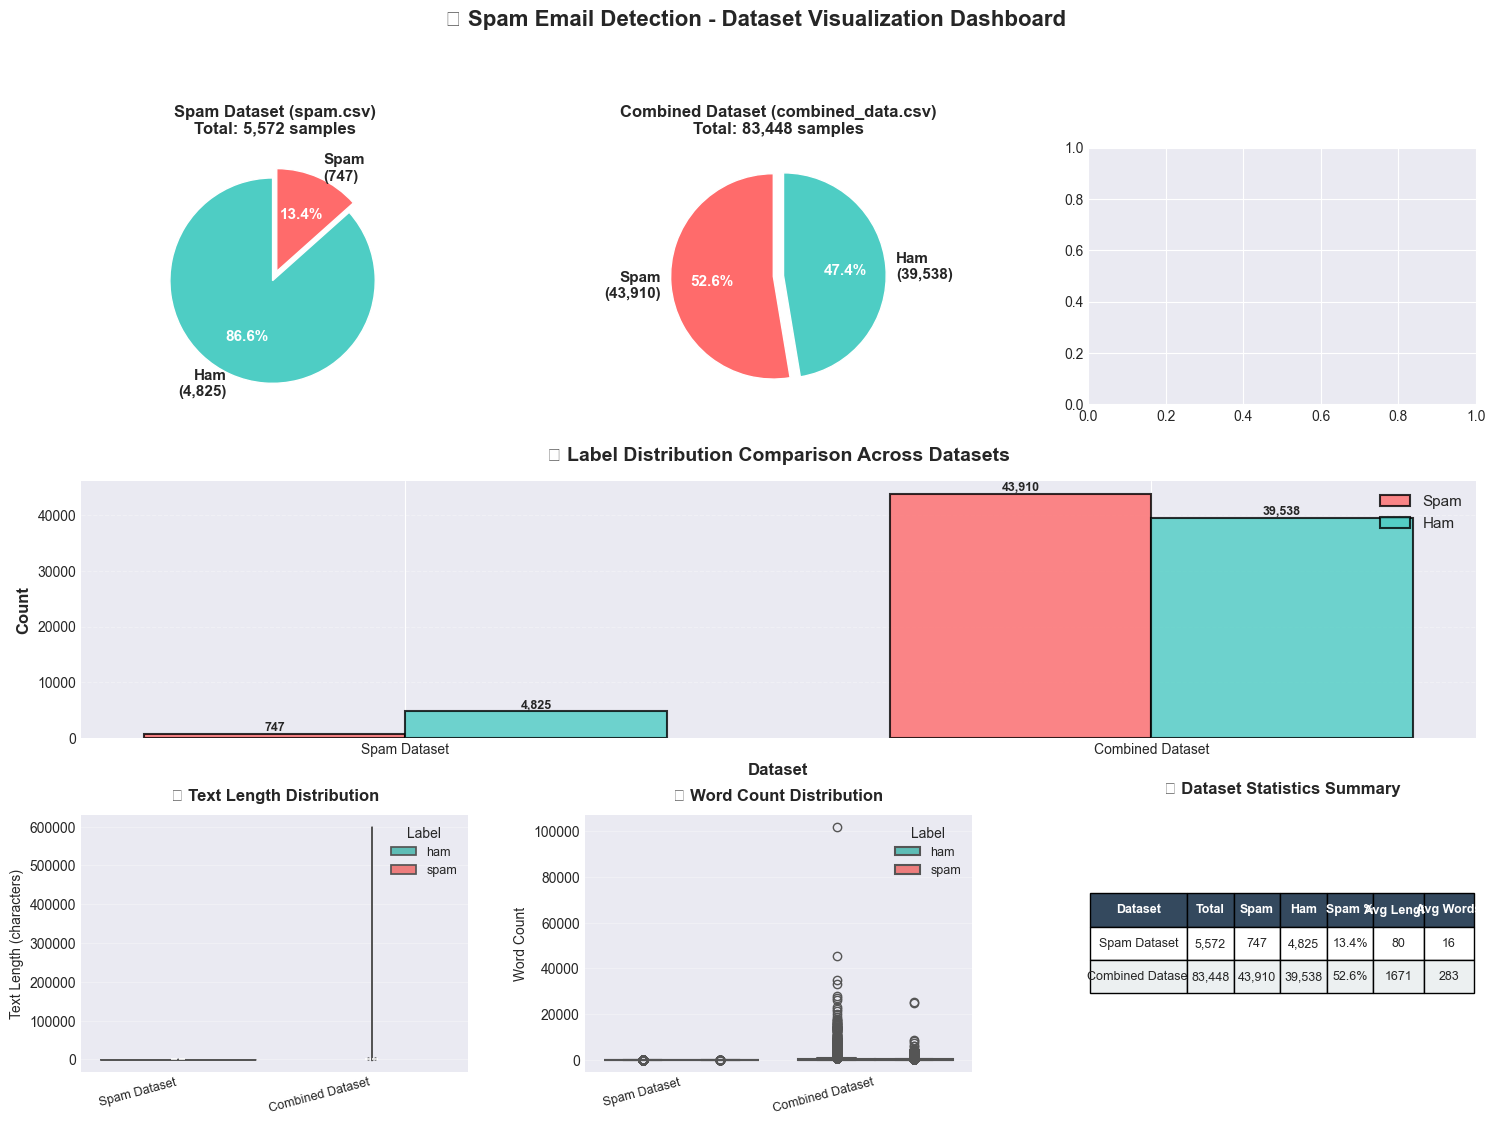


📊 DETAILED STATISTICS

Spam Dataset (spam.csv):
  Total Samples: 5,572
  Spam: 747 (13.41%)
  Ham: 4,825 (86.59%)
  Average Text Length: 80 characters
  Average Word Count: 16 words

Combined Dataset (combined_data.csv):
  Total Samples: 83,448
  Spam: 43,910 (52.62%)
  Ham: 39,538 (47.38%)
  Average Text Length: 1671 characters
  Average Word Count: 283 words


In [16]:
# 📊 Beautiful Dataset Visualization
# Visualize individual datasets before combining

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import numpy as np

# Set modern styling
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define attractive color scheme
colors = {
    'spam': '#FF6B6B',  # Coral red
    'ham': '#4ECDC4',   # Turquoise
    'accent1': '#95E1D3',  # Mint
    'accent2': '#F38181',  # Pink
    'bg': '#FFEAA7',    # Light yellow
}

# Load individual datasets for visualization
datasets_to_visualize = []

# Load spam.csv
# Note: Using ../datasets/ because notebook is in notebooks/ folder
try:
    spam_data = load_spam_dataset('../datasets/spam.csv')
    if spam_data is not None:
        spam_data['dataset'] = 'Spam Dataset (spam.csv)'
        datasets_to_visualize.append(spam_data)
except:
    pass

# Load combined_data.csv
try:
    combined_data = load_spam_dataset('../datasets/combined_data.csv')
    if combined_data is not None:
        combined_data['dataset'] = 'Combined Dataset (combined_data.csv)'
        datasets_to_visualize.append(combined_data)
except:
    pass

if datasets_to_visualize:
    print("="*80)
    print("📊 DATASET VISUALIZATION")
    print("="*80)
    
    # Calculate statistics for each dataset
    stats_list = []
    for df in datasets_to_visualize:
        df['text_length'] = df['text'].str.len()
        df['word_count'] = df['text'].str.split().str.len()
        
        stats = {
            'Dataset': df['dataset'].iloc[0],
            'Total Samples': len(df),
            'Spam Count': len(df[df['label'] == 'spam']),
            'Ham Count': len(df[df['label'] == 'ham']),
            'Spam %': (len(df[df['label'] == 'spam']) / len(df)) * 100,
            'Avg Text Length': df['text_length'].mean(),
            'Avg Word Count': df['word_count'].mean(),
        }
        stats_list.append(stats)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Dataset Overview - Pie Charts
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    axes_pie = [ax1, ax2, ax3]
    for idx, df in enumerate(datasets_to_visualize[:3]):
        if idx < len(axes_pie):
            label_counts = df['label'].value_counts()
            colors_pie = [colors['spam'] if label == 'spam' else colors['ham'] for label in label_counts.index]
            
            wedges, texts, autotexts = axes_pie[idx].pie(
                label_counts.values,
                labels=[f'{label.title()}\n({count:,})' for label, count in zip(label_counts.index, label_counts.values)],
                colors=colors_pie,
                autopct='%1.1f%%',
                startangle=90,
                textprops={'fontsize': 11, 'fontweight': 'bold'},
                explode=(0.05, 0.05)
            )
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
            
            axes_pie[idx].set_title(f'{df["dataset"].iloc[0]}\nTotal: {len(df):,} samples', 
                                  fontsize=12, fontweight='bold', pad=10)
    
    # 2. Label Distribution Comparison - Bar Chart
    ax4 = fig.add_subplot(gs[1, :])
    dataset_names = [df['dataset'].iloc[0] for df in datasets_to_visualize]
    
    spam_counts = [len(df[df['label'] == 'spam']) for df in datasets_to_visualize]
    ham_counts = [len(df[df['label'] == 'ham']) for df in datasets_to_visualize]
    
    x = np.arange(len(dataset_names))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, spam_counts, width, label='Spam', color=colors['spam'], alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax4.bar(x + width/2, ham_counts, width, label='Ham', color=colors['ham'], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax4.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax4.set_title('📊 Label Distribution Comparison Across Datasets', fontsize=14, fontweight='bold', pad=15)
    ax4.set_xticks(x)
    ax4.set_xticklabels([name.split('(')[0].strip() for name in dataset_names], rotation=0, ha='center', fontsize=10)
    ax4.legend(fontsize=11, loc='upper right')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 3. Text Length Distribution - Violin Plot
    ax5 = fig.add_subplot(gs[2, 0])
    all_data_length = pd.concat([df[['text_length', 'label', 'dataset']] for df in datasets_to_visualize])
    
    sns.violinplot(data=all_data_length, x='dataset', y='text_length', hue='label',
                   palette={'spam': colors['spam'], 'ham': colors['ham']},
                   ax=ax5, split=True, inner='box')
    ax5.set_title('📏 Text Length Distribution', fontsize=12, fontweight='bold', pad=10)
    ax5.set_xlabel('')
    ax5.set_ylabel('Text Length (characters)', fontsize=10)
    ax5.set_xticklabels([name.split('(')[0].strip() for name in all_data_length['dataset'].unique()], 
                       rotation=15, ha='right', fontsize=9)
    ax5.legend(title='Label', fontsize=9, title_fontsize=10)
    ax5.grid(axis='y', alpha=0.3)
    
    # 4. Word Count Distribution - Box Plot
    ax6 = fig.add_subplot(gs[2, 1])
    all_data_words = pd.concat([df[['word_count', 'label', 'dataset']] for df in datasets_to_visualize])
    
    sns.boxplot(data=all_data_words, x='dataset', y='word_count', hue='label',
                palette={'spam': colors['spam'], 'ham': colors['ham']},
                ax=ax6, linewidth=1.5)
    ax6.set_title('📝 Word Count Distribution', fontsize=12, fontweight='bold', pad=10)
    ax6.set_xlabel('')
    ax6.set_ylabel('Word Count', fontsize=10)
    ax6.set_xticklabels([name.split('(')[0].strip() for name in all_data_words['dataset'].unique()], 
                       rotation=15, ha='right', fontsize=9)
    ax6.legend(title='Label', fontsize=9, title_fontsize=10)
    ax6.grid(axis='y', alpha=0.3)
    
    # 5. Statistics Table
    ax7 = fig.add_subplot(gs[2, 2])
    ax7.axis('tight')
    ax7.axis('off')
    
    stats_df = pd.DataFrame(stats_list)
    table_data = []
    for stat in stats_list:
        table_data.append([
            stat['Dataset'].split('(')[0].strip(),
            f"{stat['Total Samples']:,}",
            f"{stat['Spam Count']:,}",
            f"{stat['Ham Count']:,}",
            f"{stat['Spam %']:.1f}%",
            f"{stat['Avg Text Length']:.0f}",
            f"{stat['Avg Word Count']:.0f}"
        ])
    
    table = ax7.table(cellText=table_data,
                     colLabels=['Dataset', 'Total', 'Spam', 'Ham', 'Spam %', 'Avg Length', 'Avg Words'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.25, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13])
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(7):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#34495e')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#ecf0f1' if i % 2 == 0 else 'white')
    
    ax7.set_title('📈 Dataset Statistics Summary', fontsize=12, fontweight='bold', pad=15)
    
    plt.suptitle('🎯 Spam Email Detection - Dataset Visualization Dashboard', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*80)
    print("📊 DETAILED STATISTICS")
    print("="*80)
    for stat in stats_list:
        print(f"\n{stat['Dataset']}:")
        print(f"  Total Samples: {stat['Total Samples']:,}")
        print(f"  Spam: {stat['Spam Count']:,} ({stat['Spam %']:.2f}%)")
        print(f"  Ham: {stat['Ham Count']:,} ({100-stat['Spam %']:.2f}%)")
        print(f"  Average Text Length: {stat['Avg Text Length']:.0f} characters")
        print(f"  Average Word Count: {stat['Avg Word Count']:.0f} words")
    
else:
    print("⚠️  No datasets available for visualization")


## 2. Exploratory Data Analysis


In [19]:
# Exploratory Data Analysis
if data is not None:
    print("="*60)
    print("DATASET OVERVIEW")
    print("="*60)
    print(f"Total samples: {len(data)}")
    print(f"Features: {data.shape[1]}")
    print(f"\nLabel distribution:")
    print(data['label'].value_counts())
    print(f"\nPercentage distribution:")
    print(data['label'].value_counts(normalize=True) * 100)
    
    # Check for missing values
    print(f"\nMissing values:\n{data.isnull().sum()}")
    
    # Display sample data
    print("\n" + "="*60)
    print("SAMPLE DATA")
    print("="*60)
    print(data.head(10))


DATASET OVERVIEW
Total samples: 88603
Features: 2

Label distribution:
label
spam    44549
ham     44054
Name: count, dtype: int64

Percentage distribution:
label
spam    50.279336
ham     49.720664
Name: proportion, dtype: float64

Missing values:
label    0
text     0
dtype: int64

SAMPLE DATA
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...



TEXT STATISTICS

Average text length by label:
label
ham     1912.304603
spam    1248.966980
Name: text_length, dtype: float64

Average word count by label:
label
ham     329.096586
spam    206.325305
Name: word_count, dtype: float64


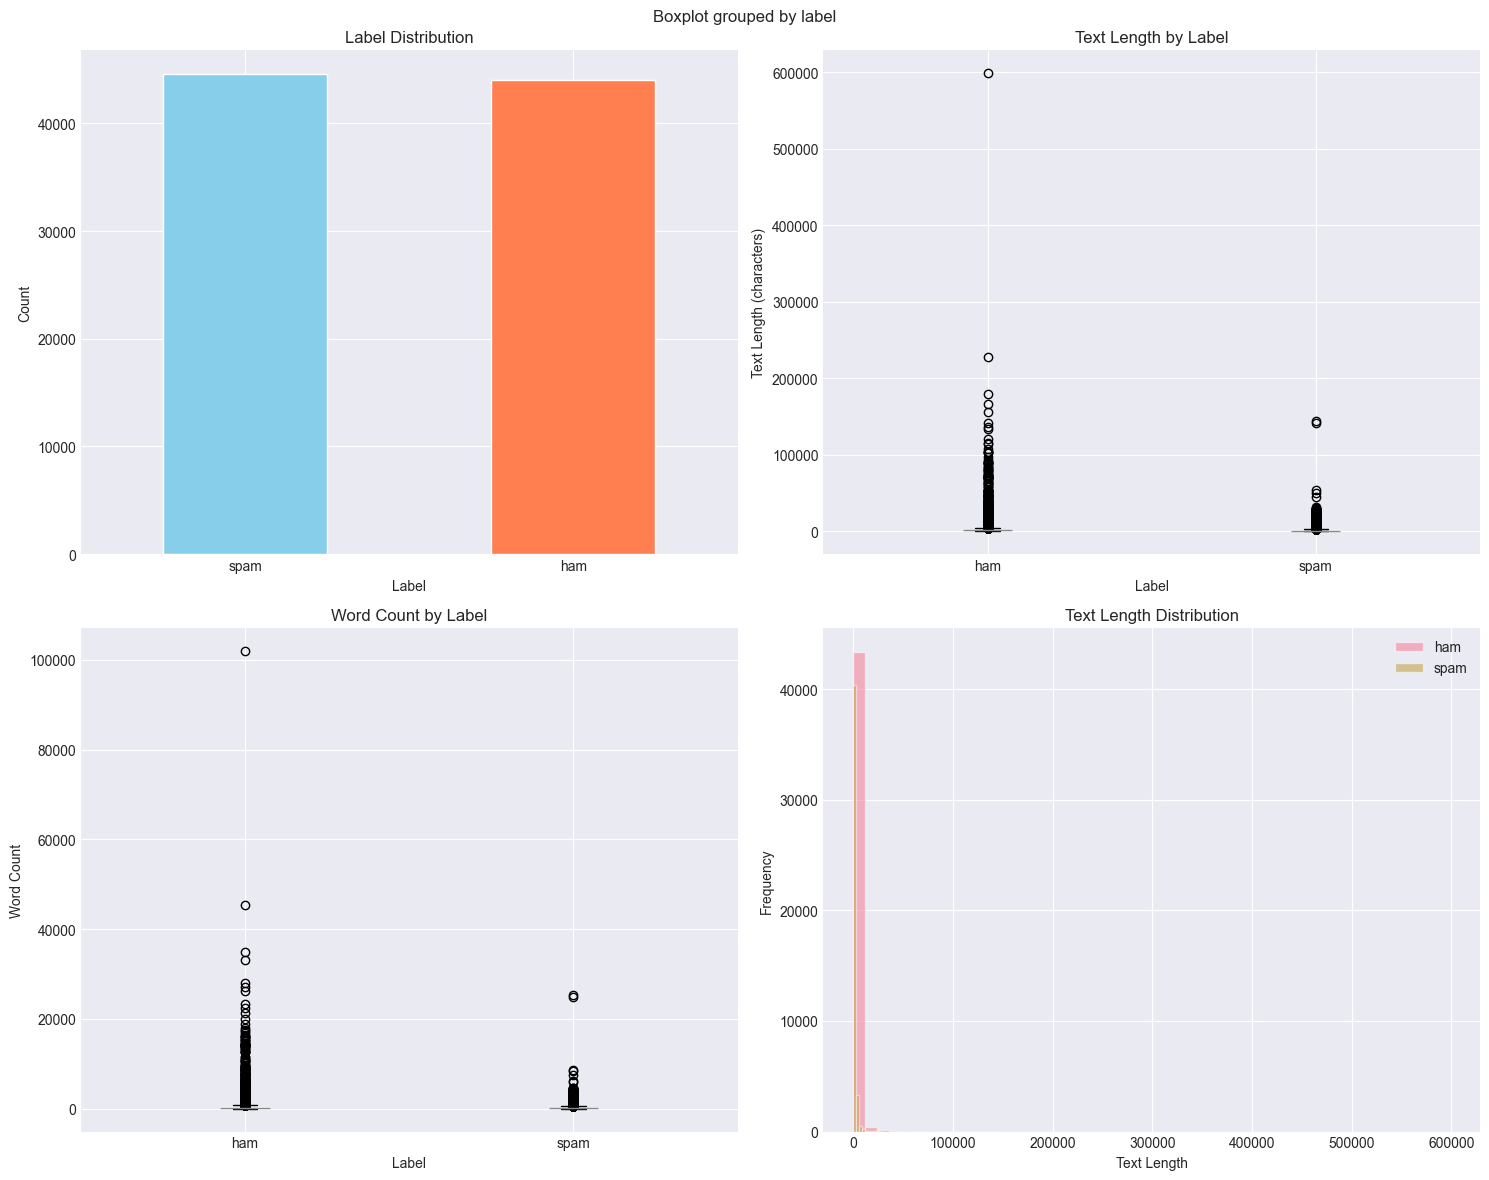

In [21]:
# Statistical analysis of text length
if data is not None:
    data['text_length'] = data['text'].str.len()
    data['word_count'] = data['text'].str.split().str.len()
    
    print("\n" + "="*60)
    print("TEXT STATISTICS")
    print("="*60)
    print("\nAverage text length by label:")
    print(data.groupby('label')['text_length'].mean())
    
    print("\nAverage word count by label:")
    print(data.groupby('label')['word_count'].mean())
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Label distribution
    data['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'coral'])
    axes[0,0].set_title('Label Distribution')
    axes[0,0].set_xlabel('Label')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=0)
    
    # Text length distribution
    data.boxplot(column='text_length', by='label', ax=axes[0,1])
    axes[0,1].set_title('Text Length by Label')
    axes[0,1].set_xlabel('Label')
    axes[0,1].set_ylabel('Text Length (characters)')
    
    # Word count distribution
    data.boxplot(column='word_count', by='label', ax=axes[1,0])
    axes[1,0].set_title('Word Count by Label')
    axes[1,0].set_xlabel('Label')
    axes[1,0].set_ylabel('Word Count')
    
    # Histogram of text lengths
    for label in data['label'].unique():
        axes[1,1].hist(data[data['label']==label]['text_length'], 
                      bins=50, alpha=0.5, label=label)
    axes[1,1].set_title('Text Length Distribution')
    axes[1,1].set_xlabel('Text Length')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No data available for analysis")


## 3. Feature Engineering

Extract additional features that help distinguish spam from ham:
- Common spam words
- URL count
- Special characters
- Uppercase letters
- etc.


In [22]:
# Feature Engineering Functions
def extract_features(text):
    """
    Extract statistical and linguistic features from email text
    """
    features = {}
    
    # Basic features
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    
    # Character features
    features['uppercase_count'] = sum(1 for c in text if c.isupper())
    features['uppercase_ratio'] = features['uppercase_count'] / max(len(text), 1)
    features['digits_count'] = sum(1 for c in text if c.isdigit())
    features['digits_ratio'] = features['digits_count'] / max(len(text), 1)
    
    # Special characters
    special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=']
    features['special_char_count'] = sum(text.count(char) for char in special_chars)
    
    # URL patterns
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    features['url_count'] = len(re.findall(url_pattern, text.lower()))
    
    # Email patterns
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    features['email_count'] = len(re.findall(email_pattern, text.lower()))
    
    # Common spam words (case-insensitive)
    spam_words = ['free', 'winner', 'congratulations', 'prize', 'click', 'limited', 
                  'offer', 'urgent', 'deal', 'money', 'cash', 'winner', 'winner', 
                  'win', 'click here', 'claim now', 'act now', 'expire', 'special',
                  'guaranteed', 'risk free', 'no credit check', 'winner', 'congrats']
    text_lower = text.lower()
    features['spam_word_count'] = sum(1 for word in spam_words if word in text_lower)
    
    # Exclamation and question marks
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    
    return features

# Apply feature extraction
if 'data' in locals() or 'data' in globals():
    if data is not None:
        print("Extracting features from email text...")
        feature_list = []
        for text in data['text']:
            feature_list.append(extract_features(text))
        
        features_df = pd.DataFrame(feature_list)
        data_features = pd.concat([data, features_df], axis=1)
        
        print("✅ Feature extraction complete!")
        print(f"Total features: {features_df.shape[1]}")
        print("\nFeature statistics:")
        print(features_df.describe())
    else:
        print("⚠️  No data available for feature extraction")
else:
    print("⚠️  Data not loaded yet. Please run Cell 3 first to load the dataset.")


Extracting features from email text...
✅ Feature extraction complete!
Total features: 12

Feature statistics:
              length     word_count  uppercase_count  uppercase_ratio  \
count   88603.000000   88603.000000     88603.000000     88603.000000   
mean     1578.782852     267.368001         8.199666         0.006242   
std      4084.554012     706.244454       178.931648         0.042413   
min         1.000000       1.000000         0.000000         0.000000   
25%       374.000000      66.000000         0.000000         0.000000   
50%       810.000000     142.000000         0.000000         0.000000   
75%      1777.000000     297.000000         0.000000         0.000000   
max    598705.000000  101984.000000     12741.000000         1.000000   

       digits_count  digits_ratio  special_char_count     url_count  \
count  88603.000000  88603.000000        88603.000000  88603.000000   
mean      12.628308      0.011720            8.041658      0.000214   
std       64.547820


FEATURE CORRELATION WITH LABEL
⚠️  Warning: Some labels couldn't be encoded for correlation analysis

Top 10 most correlated features with spam:
uppercase_ratio               : 0.0577
spam_word_count               : 0.0238
length                        : 0.0222
digits_ratio                  : 0.0124
url_count                     : 0.0107
special_char_count            : 0.0100
email_count                   : 0.0046
digits_count                  : 0.0019
question_count                : 0.0018
exclamation_count             : 0.0011


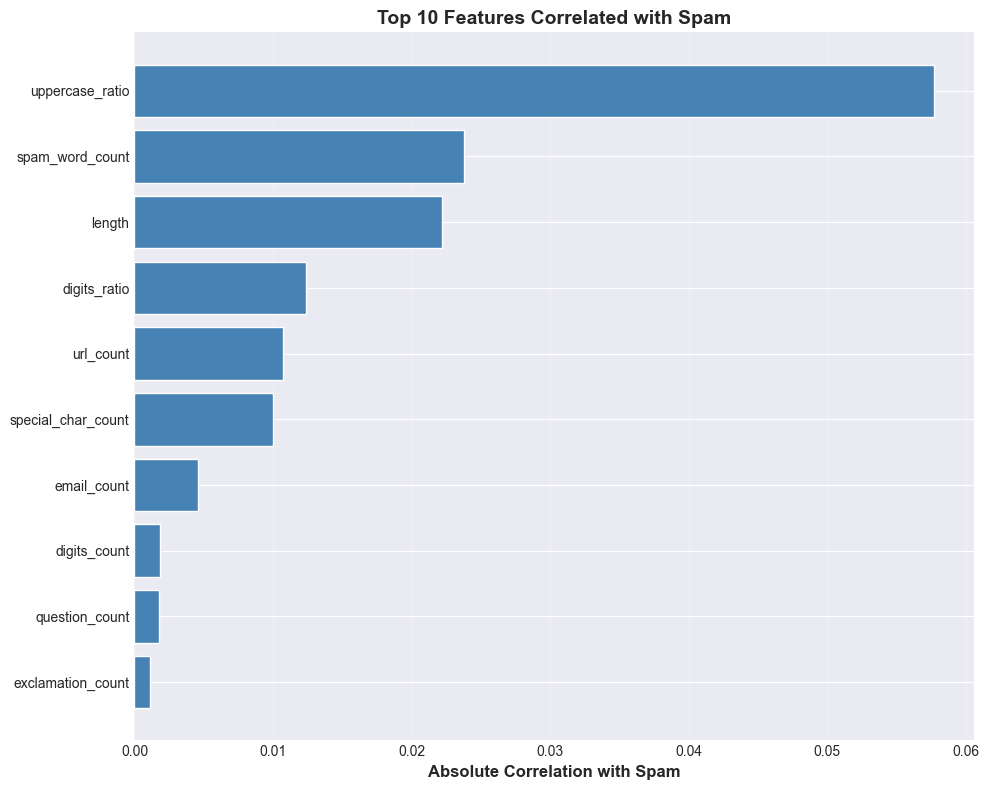

In [23]:
# Feature correlation with spam/ham
if 'data_features' in locals() or 'data_features' in globals():
    if data_features is not None and len(data_features) > 0:
        if 'features_df' in locals() or 'features_df' in globals():
            print("\n" + "="*60)
            print("FEATURE CORRELATION WITH LABEL")
            print("="*60)
            
            # Convert label to numeric for correlation
            # Clean labels first
            y_labels = data_features['label'].astype(str).str.lower().str.strip()
            label_mapping = {'ham': 0, 'spam': 1, '0': 0, '1': 1}
            data_features['label_numeric'] = y_labels.map(label_mapping)
            
            # Remove any NaN values
            if data_features['label_numeric'].isna().any():
                print(f"⚠️  Warning: Some labels couldn't be encoded for correlation analysis")
                valid_mask = data_features['label_numeric'].notna()
                data_features_corr = data_features[valid_mask].copy()
            else:
                data_features_corr = data_features.copy()
            
            # Calculate correlation with label
            numeric_features = features_df.select_dtypes(include=[np.number]).columns.tolist()
            correlations = {}
            for feature in numeric_features:
                if feature in data_features_corr.columns:
                    try:
                        corr = data_features_corr[feature].corr(data_features_corr['label_numeric'])
                        if not pd.isna(corr):
                            correlations[feature] = abs(corr)
                    except:
                        continue
            
            if correlations:
                # Sort by correlation
                sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
                
                print("\nTop 10 most correlated features with spam:")
                for feature, corr in sorted_correlations[:10]:
                    print(f"{feature:30s}: {corr:.4f}")
                
                # Visualization
                plt.figure(figsize=(10, 8))
                features_to_plot = [f[0] for f in sorted_correlations[:10]]
                corr_values = [f[1] for f in sorted_correlations[:10]]
                plt.barh(features_to_plot, corr_values, color='steelblue')
                plt.xlabel('Absolute Correlation with Spam', fontsize=12, fontweight='bold')
                plt.title('Top 10 Features Correlated with Spam', fontsize=14, fontweight='bold')
                plt.gca().invert_yaxis()
                plt.grid(axis='x', alpha=0.3)
                plt.tight_layout()
                plt.show()
            else:
                print("⚠️  No correlations could be calculated")
        else:
            print("⚠️  features_df not found. Please run feature engineering cell first.")
    else:
        print("⚠️  data_features is empty or None. Please run feature engineering cell first.")
else:
    print("⚠️  data_features not found. Please run feature engineering and preprocessing cells first.")


## 4. Text Preprocessing

Clean and prepare the text for NLP models:
- Remove special characters and URLs
- Convert to lowercase
- Remove stop words (optional)
- Tokenization


In [ ]:
# Text Preprocessing Functions with Advanced NLP
# Initialize lemmatizer (created once, reused for efficiency)
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, remove_stopwords=True):
    """
    Enhanced text preprocessing pipeline for NLP analysis:
    - Convert to lowercase
    - Remove URLs and email addresses
    - Remove punctuation
    - Remove stop words (default: True)
    - Lemmatization (reduce words to root form)
    
    Args:
        text: Input text string
        remove_stopwords: Whether to remove stop words (default: True)
    
    Returns:
        Preprocessed text string
    """
    # Handle None or non-string input
    if text is None or not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
                  '', text)
    
    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 
                  '', text)
    
    # Remove punctuation (using string.punctuation for comprehensive removal)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize text into words (with error handling)
    try:
        words = word_tokenize(text)
    except LookupError:
        # If punkt_tab is not available, use simple split as fallback
        print("⚠️  punkt_tab not available, using simple word splitting")
        words = text.split()
    
    # Remove stop words if requested
    if remove_stopwords:
        try:
            stop_words = set(stopwords.words('english'))
            words = [word for word in words if word not in stop_words]
        except LookupError:
            print("⚠️  Stopwords not available, skipping stopword removal")
    
    # Lemmatization - reduce words to their root form (e.g., "running" -> "run")
    if lemmatizer is not None:
        try:
            words = [lemmatizer.lemmatize(word) for word in words]
        except (LookupError, AttributeError):
            # If wordnet data is missing, skip lemmatization
            pass
    else:
        # Skip lemmatization if lemmatizer is not available
        pass
    
    # Join words back into text
    text = ' '.join(words)
    
    # Final cleanup: remove any remaining extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing with error handling
if data is not None:
    print("Preprocessing text data...")
    try:
        # Use apply with error handling for individual rows
        def safe_preprocess(x):
            try:
                return preprocess_text(x, remove_stopwords=False)
            except Exception as e:
                print(f"⚠️  Error preprocessing text: {e}")
                # Return original text if preprocessing fails
                return str(x) if x is not None else ""
        
        data['text_processed'] = data['text'].apply(safe_preprocess)
        print("✅ Preprocessing complete!")
        print("\nSample before preprocessing:")
        print(data['text'].iloc[0][:200])
        print("\nSample after preprocessing:")
        print(data['text_processed'].iloc[0][:200])
    except Exception as e:
        print(f"❌ Error during preprocessing: {e}")
        print("Attempting to continue with basic preprocessing...")
        # Fallback: simple lowercase and strip
        data['text_processed'] = data['text'].astype(str).str.lower().str.strip()
        print("⚠️  Used basic preprocessing (lowercase + strip) due to errors")
else:
    print("⚠️  No data available for preprocessing")


✅ NLTK data and lemmatizer initialized successfully
Preprocessing text data...
✅ Preprocessing complete!

Sample before preprocessing:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Sample after preprocessing:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


## 5. Model Training

Train multiple classification models:
1. **Naive Bayes** - Fast and effective for text classification
2. **Logistic Regression** - Good baseline with interpretable features
3. **Random Forest** - Ensemble method for better accuracy
4. **SVM** - Support Vector Machine with linear kernel

We'll use **TF-IDF** (Term Frequency-Inverse Document Frequency) for text vectorization.


In [29]:
# Prepare data for training
if 'data_features' in locals() or 'data_features' in globals():
    if data_features is not None and len(data_features) > 0:
        # Split into features and target
        X = data_features['text_processed'] if 'text_processed' in data_features.columns else data_features['text']
        y = data_features['label']
        
        # Inspect labels before encoding
        print(f"\n🔍 Inspecting labels before encoding...")
        print(f"Label value counts:\n{y.value_counts()}")
        print(f"Unique labels: {y.unique()}")
        print(f"Any NaN values: {y.isna().sum()}")
        
        # Clean and standardize labels (convert to lowercase, strip whitespace)
        y_clean = y.astype(str).str.lower().str.strip()
        
        # Encode labels properly - handle various formats
        def encode_label(label):
            label_str = str(label).lower().strip()
            if label_str == 'ham' or label_str == '0':
                return 0
            elif label_str == 'spam' or label_str == '1':
                return 1
            else:
                return None
        
        y_encoded = y_clean.apply(encode_label)
        
        # Remove any NaN values after encoding
        if y_encoded.isna().any():
            nan_count = y_encoded.isna().sum()
            print(f"\n⚠️  Warning: {nan_count} labels couldn't be encoded. Removing them...")
            print(f"Unencodable labels: {y_clean[y_encoded.isna()].unique()}")
            valid_mask = y_encoded.notna()
            X = X[valid_mask]
            y_encoded = y_encoded[valid_mask]
        
        if len(X) == 0:
            print("⚠️  No valid data available after encoding!")
        else:
            print(f"\n✅ Encoding complete!")
            print(f"Encoded label distribution:\n{y_encoded.value_counts().sort_index()}")
            
            # Check if we have at least 2 samples in each class for stratification
            class_counts = y_encoded.value_counts()
            can_stratify = len(class_counts) >= 2 and class_counts.min() >= 2
            
            if can_stratify:
                # Split into train and test sets (80/20 split) with stratification
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
                )
            else:
                print(f"⚠️  Warning: Not enough samples for stratification. Using random split...")
                # Split without stratification
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y_encoded, test_size=0.2, random_state=42
                )
            
            print(f"\n✅ Data split successfully!")
            print(f"Training set size: {len(X_train):,}")
            print(f"Test set size: {len(X_test):,}")
            print(f"Training spam ratio: {y_train.mean():.2%}")
            print(f"Test spam ratio: {y_test.mean():.2%}")
            print(f"\nTraining label distribution:\n{y_train.value_counts().sort_index()}")
            print(f"\nTest label distribution:\n{y_test.value_counts().sort_index()}")
    else:
        print("⚠️  data_features is empty or None. Please run feature engineering and preprocessing cells first.")
elif 'data' in locals() or 'data' in globals():
    if data is not None and len(data) > 0:
        print("⚠️  data_features not found. Using basic data split (run feature engineering first for better results)...")
        X = data['text_processed'] if 'text_processed' in data.columns else data['text']
        y = data['label']
        
        # Clean and encode labels
        y_clean = y.astype(str).str.lower().str.strip()
        def encode_label(label):
            label_str = str(label).lower().strip()
            if label_str == 'ham' or label_str == '0':
                return 0
            elif label_str == 'spam' or label_str == '1':
                return 1
            else:
                return None
        
        y_encoded = y_clean.apply(encode_label)
        
        # Remove NaN values
        if y_encoded.isna().any():
            valid_mask = y_encoded.notna()
            X = X[valid_mask]
            y_encoded = y_encoded[valid_mask]
        
        # Check stratification
        class_counts = y_encoded.value_counts()
        can_stratify = len(class_counts) >= 2 and class_counts.min() >= 2
        
        if can_stratify:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
            )
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_encoded, test_size=0.2, random_state=42
            )
        
        print(f"\n✅ Data prepared successfully!")
        print(f"Training set size: {len(X_train):,}")
        print(f"Test set size: {len(X_test):,}")
        print(f"Training spam ratio: {y_train.mean():.2%}")
        print(f"Test spam ratio: {y_test.mean():.2%}")
    else:
        print("⚠️  No data available for training. Please run Cell 3 first to load the dataset.")
else:
    print("⚠️  Data not loaded yet. Please run Cell 3 first to load the dataset.")



🔍 Inspecting labels before encoding...
Label value counts:
label
spam    44549
ham     44054
Name: count, dtype: int64
Unique labels: ['ham' 'spam' nan]
Any NaN values: 417

⚠️  Warning: 417 labels couldn't be encoded. Removing them...
Unencodable labels: ['nan']

✅ Encoding complete!
Encoded label distribution:
label
0.0    44054
1.0    44549
Name: count, dtype: int64

✅ Data split successfully!
Training set size: 70,882
Test set size: 17,721
Training spam ratio: 50.28%
Test spam ratio: 50.28%

Training label distribution:
label
0.0    35243
1.0    35639
Name: count, dtype: int64

Test label distribution:
label
0.0    8811
1.0    8910
Name: count, dtype: int64


In [30]:
# TF-IDF Vectorization
if data is not None:
    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,      # Use top 5000 words
        ngram_range=(1, 2),      # Use unigrams and bigrams
        min_df=2,                # Word must appear in at least 2 documents
        max_df=0.95              # Word must not appear in more than 95% of documents
    )
    
    # Fit and transform training data
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    print(f"✅ TF-IDF transformation complete!")
    print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
    print(f"Training matrix shape: {X_train_tfidf.shape}")
    print(f"Test matrix shape: {X_test_tfidf.shape}")
else:
    print("⚠️  No data available for vectorization")


✅ TF-IDF transformation complete!
Vocabulary size: 5000
Training matrix shape: (70882, 5000)
Test matrix shape: (17721, 5000)


In [ ]:
pip install xgboost

In [ ]:
# Train multiple models and compare performance
# Check if training data is available
if 'X_train_tfidf' in locals() or 'X_train_tfidf' in globals():
    if X_train_tfidf is not None and 'y_train' in locals():
        # Import XGBoost if available
        try:
            from xgboost import XGBClassifier
            XGBOOST_AVAILABLE = True
        except ImportError:
            XGBOOST_AVAILABLE = False
            print("⚠️  XGBoost not available. Install with: pip install xgboost")
        
        models = {
            'Naive Bayes': MultinomialNB(),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'SVM': SVC(kernel='linear', probability=True, random_state=42)
        }
        
        # Add XGBoost if available
        if XGBOOST_AVAILABLE:
            models['XGBoost'] = XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1,
                eval_metric='logloss'
            )
        
        results = []
        
        print("\n" + "="*80)
        print("TRAINING MODELS")
        print("="*80)
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            
            try:
                # Train model
                model.fit(X_train_tfidf, y_train)
                
                # Predictions
                y_pred = model.predict(X_test_tfidf)
                y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
                
                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                auc = roc_auc_score(y_test, y_pred_proba)
                
                results.append({
                    'Model': name,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-Score': f1,
                    'AUC': auc
                })
                
                print(f"✅ {name} trained!")
                print(f"   Accuracy: {accuracy:.4f}")
                print(f"   Precision: {precision:.4f}")
                print(f"   Recall: {recall:.4f}")
                print(f"   F1-Score: {f1:.4f}")
                print(f"   AUC: {auc:.4f}")
            except Exception as e:
                print(f"❌ Error training {name}: {str(e)}")
                continue
        
        if results:
            # Create results dataframe
            results_df = pd.DataFrame(results)
            
            print("\n" + "="*80)
            print("MODEL COMPARISON")
            print("="*80)
            print(results_df.to_string(index=False))
            
            # Store models and results for later use
            print(f"\n✅ {len(models)} model(s) trained successfully!")
        else:
            print("\n⚠️  No models were trained successfully")
    else:
        print("⚠️  Training data not available. Please run data preparation and TF-IDF vectorization cells first.")
else:
    print("⚠️  X_train_tfidf not found. Please run:")
    print("   1. Cell 3: Load dataset")
    print("   2. Cell 9: Feature engineering")
    print("   3. Cell 11: Text preprocessing")
    print("   4. Cell 14: Prepare data for training")
    print("   5. Cell 15: TF-IDF vectorization")


⚠️  XGBoost not available. Install with: pip install xgboost

TRAINING MODELS

Training Naive Bayes...
✅ Naive Bayes trained!
   Accuracy: 0.9272
   Precision: 0.9007
   Recall: 0.9612
   F1-Score: 0.9300
   AUC: 0.9864

Training Logistic Regression...
✅ Logistic Regression trained!
   Accuracy: 0.9628
   Precision: 0.9586
   Recall: 0.9677
   F1-Score: 0.9631
   AUC: 0.9942

Training Random Forest...
✅ Random Forest trained!
   Accuracy: 0.9768
   Precision: 0.9734
   Recall: 0.9806
   F1-Score: 0.9770
   AUC: 0.9970

Training SVM...


## 6. Model Evaluation & Visualization

Visualize model performance with:
- Confusion matrices
- ROC curves
- Performance comparison charts


## 6.1 Hyperparameter Tuning

Optimize hyperparameters for the best performing models to improve accuracy.


In [ ]:
# Hyperparameter Tuning for Top Models
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time

if 'results_df' in locals() and len(results_df) > 0:
    # Get top 2-3 models based on F1-score
    top_models = results_df.nlargest(3, 'F1-Score')
    print("="*80)
    print("HYPERPARAMETER TUNING")
    print("="*80)
    print(f"\nTuning top {len(top_models)} models based on F1-Score:\n")
    print(top_models[['Model', 'Accuracy', 'F1-Score']].to_string(index=False))
    print("\n" + "="*80 + "\n")
    
    tuned_models = {}
    tuning_results = []
    
    # Define parameter grids for each model type
    param_grids = {
        'Naive Bayes': {
            'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
            'fit_prior': [True, False]
        },
        'Logistic Regression': {
            'C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'SVM': {
            'C': [0.1, 1.0, 10.0, 100.0],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        },
        'XGBoost': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    }
    
    for idx, row in top_models.iterrows():
        model_name = row['Model']
        print(f"\n{'='*80}")
        print(f"Tuning {model_name}...")
        print(f"{'='*80}")
        
        # Get base model
        if model_name == 'Naive Bayes':
            base_model = MultinomialNB()
        elif model_name == 'Logistic Regression':
            base_model = LogisticRegression(max_iter=1000, random_state=42)
        elif model_name == 'Random Forest':
            base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
        elif model_name == 'SVM':
            base_model = SVC(probability=True, random_state=42)
        elif model_name == 'XGBoost' and XGBOOST_AVAILABLE:
            base_model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
        else:
            print(f"⚠️  Skipping {model_name} - model not available or not in tuning grid")
            continue
        
        # Get parameter grid
        if model_name not in param_grids:
            print(f"⚠️  No parameter grid defined for {model_name}, skipping...")
            continue
        
        param_grid = param_grids[model_name]
        
        # Use RandomizedSearchCV for faster tuning (sample 20 combinations)
        start_time = time.time()
        random_search = RandomizedSearchCV(
            base_model,
            param_distributions=param_grid,
            n_iter=20,  # Number of parameter settings sampled
            cv=3,  # 3-fold cross-validation
            scoring='f1',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        random_search.fit(X_train_tfidf, y_train)
        tuning_time = time.time() - start_time
        
        # Evaluate on test set
        y_pred_tuned = random_search.predict(X_test_tfidf)
        y_pred_proba_tuned = random_search.predict_proba(X_test_tfidf)[:, 1]
        
        # Calculate metrics
        acc_tuned = accuracy_score(y_test, y_pred_tuned)
        prec_tuned = precision_score(y_test, y_pred_tuned)
        rec_tuned = recall_score(y_test, y_pred_tuned)
        f1_tuned = f1_score(y_test, y_pred_tuned)
        auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
        
        # Compare with original
        original_f1 = row['F1-Score']
        improvement = f1_tuned - original_f1
        
        print(f"\n✅ Tuning completed in {tuning_time:.2f} seconds")
        print(f"\nBest Parameters:")
        for param, value in random_search.best_params_.items():
            print(f"  {param}: {value}")
        print(f"\nPerformance Comparison:")
        print(f"  Original F1-Score: {original_f1:.4f}")
        print(f"  Tuned F1-Score:   {f1_tuned:.4f}")
        print(f"  Improvement:      {improvement:+.4f} ({improvement/original_f1*100:+.2f}%)")
        print(f"  Accuracy:         {acc_tuned:.4f}")
        print(f"  Precision:        {prec_tuned:.4f}")
        print(f"  Recall:           {rec_tuned:.4f}")
        print(f"  AUC-ROC:          {auc_tuned:.4f}")
        
        # Store tuned model
        tuned_models[f"{model_name} (Tuned)"] = random_search.best_estimator_
        
        # Store results
        tuning_results.append({
            'Model': f"{model_name} (Tuned)",
            'Accuracy': acc_tuned,
            'Precision': prec_tuned,
            'Recall': rec_tuned,
            'F1-Score': f1_tuned,
            'AUC-ROC': auc_tuned,
            'Improvement': improvement,
            'Best Params': str(random_search.best_params_)
        })
    
    # Create DataFrame for tuned results
    if tuning_results:
        tuning_df = pd.DataFrame(tuning_results)
        print("\n" + "="*80)
        print("HYPERPARAMETER TUNING SUMMARY")
        print("="*80)
        print(tuning_df[['Model', 'Accuracy', 'F1-Score', 'Improvement']].to_string(index=False))
        
        # Update results_df to include tuned models
        tuning_summary = tuning_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]
        results_df = pd.concat([results_df, tuning_summary], ignore_index=True)
        
        print("\n✅ Tuned models added to results!")
        print(f"Total models now: {len(results_df)}")
    else:
        print("\n⚠️  No models were tuned.")
        
else:
    print("⚠️  No model results available. Please run model training first.")


## 6.2 Ensemble Model (Voting Classifier)

Create an ensemble model that combines the best performing models for more robust predictions.


In [ ]:
# Create Ensemble Model (Voting Classifier)
from sklearn.ensemble import VotingClassifier

if 'results_df' in locals() and len(results_df) > 0:
    print("="*80)
    print("CREATING ENSEMBLE MODEL")
    print("="*80)
    
    # Get top 3 models (excluding tuned versions to avoid duplicates)
    base_results = results_df[~results_df['Model'].str.contains('Tuned', na=False)]
    top_3_models = base_results.nlargest(3, 'F1-Score')
    
    print(f"\nTop 3 models for ensemble:")
    print(top_3_models[['Model', 'Accuracy', 'F1-Score']].to_string(index=False))
    print()
    
    # Create base models for ensemble
    ensemble_estimators = []
    
    for idx, row in top_3_models.iterrows():
        model_name = row['Model']
        
        if model_name == 'Naive Bayes':
            ensemble_estimators.append(('nb', MultinomialNB()))
        elif model_name == 'Logistic Regression':
            ensemble_estimators.append(('lr', LogisticRegression(max_iter=1000, random_state=42)))
        elif model_name == 'Random Forest':
            ensemble_estimators.append(('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))
        elif model_name == 'SVM':
            ensemble_estimators.append(('svm', SVC(kernel='linear', probability=True, random_state=42)))
        elif model_name == 'XGBoost' and XGBOOST_AVAILABLE:
            ensemble_estimators.append(('xgb', XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1,
                eval_metric='logloss'
            )))
    
    if len(ensemble_estimators) >= 2:
        # Create Voting Classifier with soft voting (uses probabilities)
        print(f"Creating Voting Classifier with {len(ensemble_estimators)} models...")
        ensemble_model = VotingClassifier(
            estimators=ensemble_estimators,
            voting='soft',  # Use probabilities for better performance
            n_jobs=-1
        )
        
        # Train ensemble model
        print("Training ensemble model...")
        start_time = time.time()
        ensemble_model.fit(X_train_tfidf, y_train)
        training_time = time.time() - start_time
        print(f"✅ Ensemble model trained in {training_time:.2f} seconds\n")
        
        # Evaluate ensemble model
        y_pred_ensemble = ensemble_model.predict(X_test_tfidf)
        y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_tfidf)[:, 1]
        
        # Calculate metrics
        acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
        prec_ensemble = precision_score(y_test, y_pred_ensemble)
        rec_ensemble = recall_score(y_test, y_pred_ensemble)
        f1_ensemble = f1_score(y_test, y_pred_ensemble)
        auc_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble)
        
        print("="*80)
        print("ENSEMBLE MODEL PERFORMANCE")
        print("="*80)
        print(f"Accuracy:  {acc_ensemble:.4f}")
        print(f"Precision: {prec_ensemble:.4f}")
        print(f"Recall:    {rec_ensemble:.4f}")
        print(f"F1-Score:  {f1_ensemble:.4f}")
        print(f"AUC-ROC:   {auc_ensemble:.4f}")
        print("="*80)
        
        # Compare with best single model
        best_single = base_results.loc[base_results['F1-Score'].idxmax()]
        improvement = f1_ensemble - best_single['F1-Score']
        
        print(f"\nComparison with Best Single Model ({best_single['Model']}):")
        print(f"  Best Single F1-Score: {best_single['F1-Score']:.4f}")
        print(f"  Ensemble F1-Score:    {f1_ensemble:.4f}")
        print(f"  Improvement:          {improvement:+.4f} ({improvement/best_single['F1-Score']*100:+.2f}%)")
        
        # Add ensemble to results
        ensemble_result = {
            'Model': 'Ensemble (Voting)',
            'Accuracy': acc_ensemble,
            'Precision': prec_ensemble,
            'Recall': rec_ensemble,
            'F1-Score': f1_ensemble,
            'AUC-ROC': auc_ensemble
        }
        
        results_df = pd.concat([results_df, pd.DataFrame([ensemble_result])], ignore_index=True)
        
        # Store ensemble model
        ensemble_best_model = ensemble_model
        ensemble_best_model_name = 'Ensemble (Voting)'
        
        print("\n✅ Ensemble model created and added to results!")
        
    else:
        print("⚠️  Need at least 2 models for ensemble. Current models available:", len(ensemble_estimators))
        
else:
    print("⚠️  No model results available. Please run model training first.")


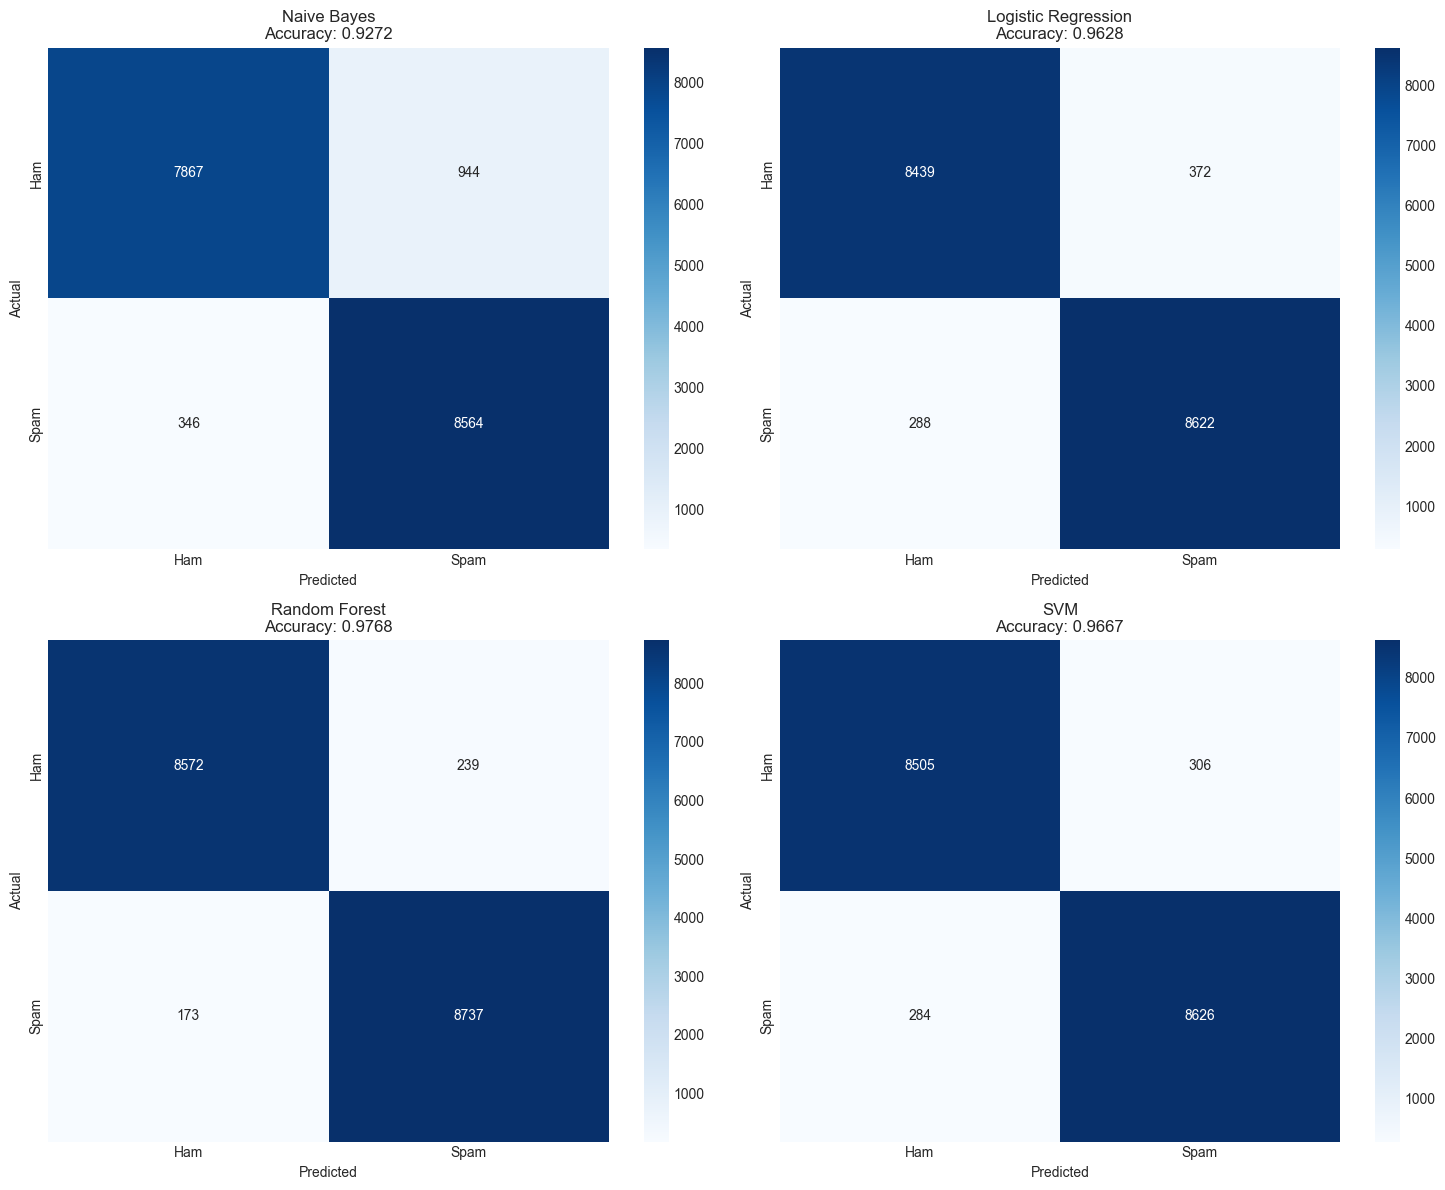

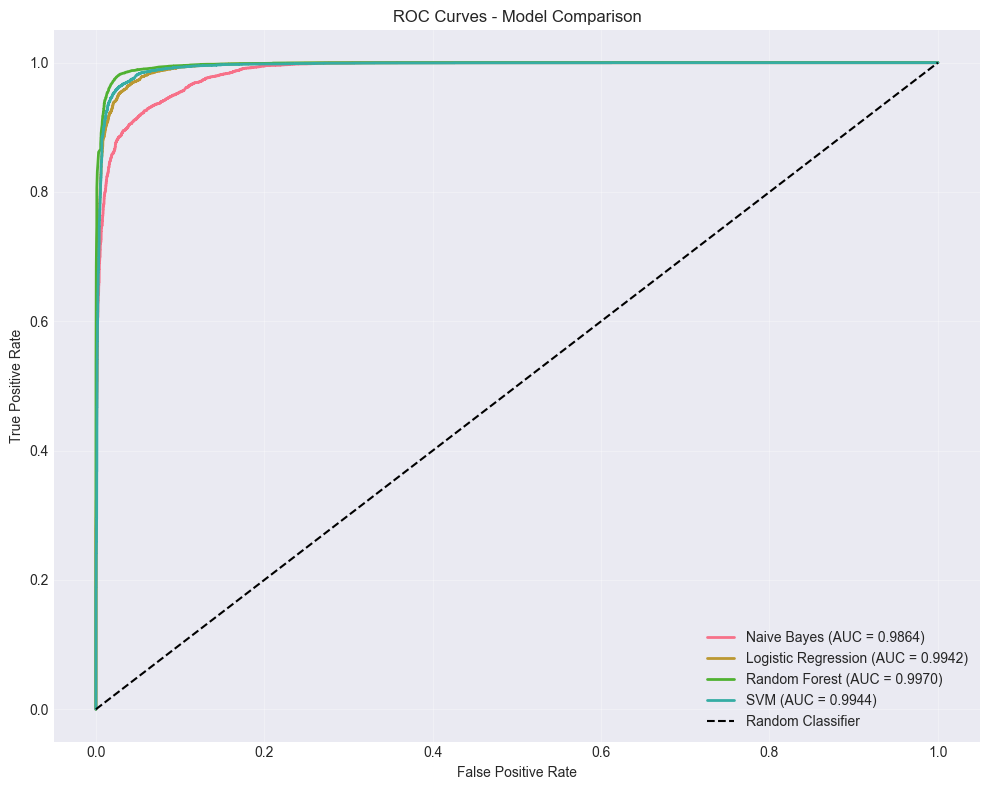

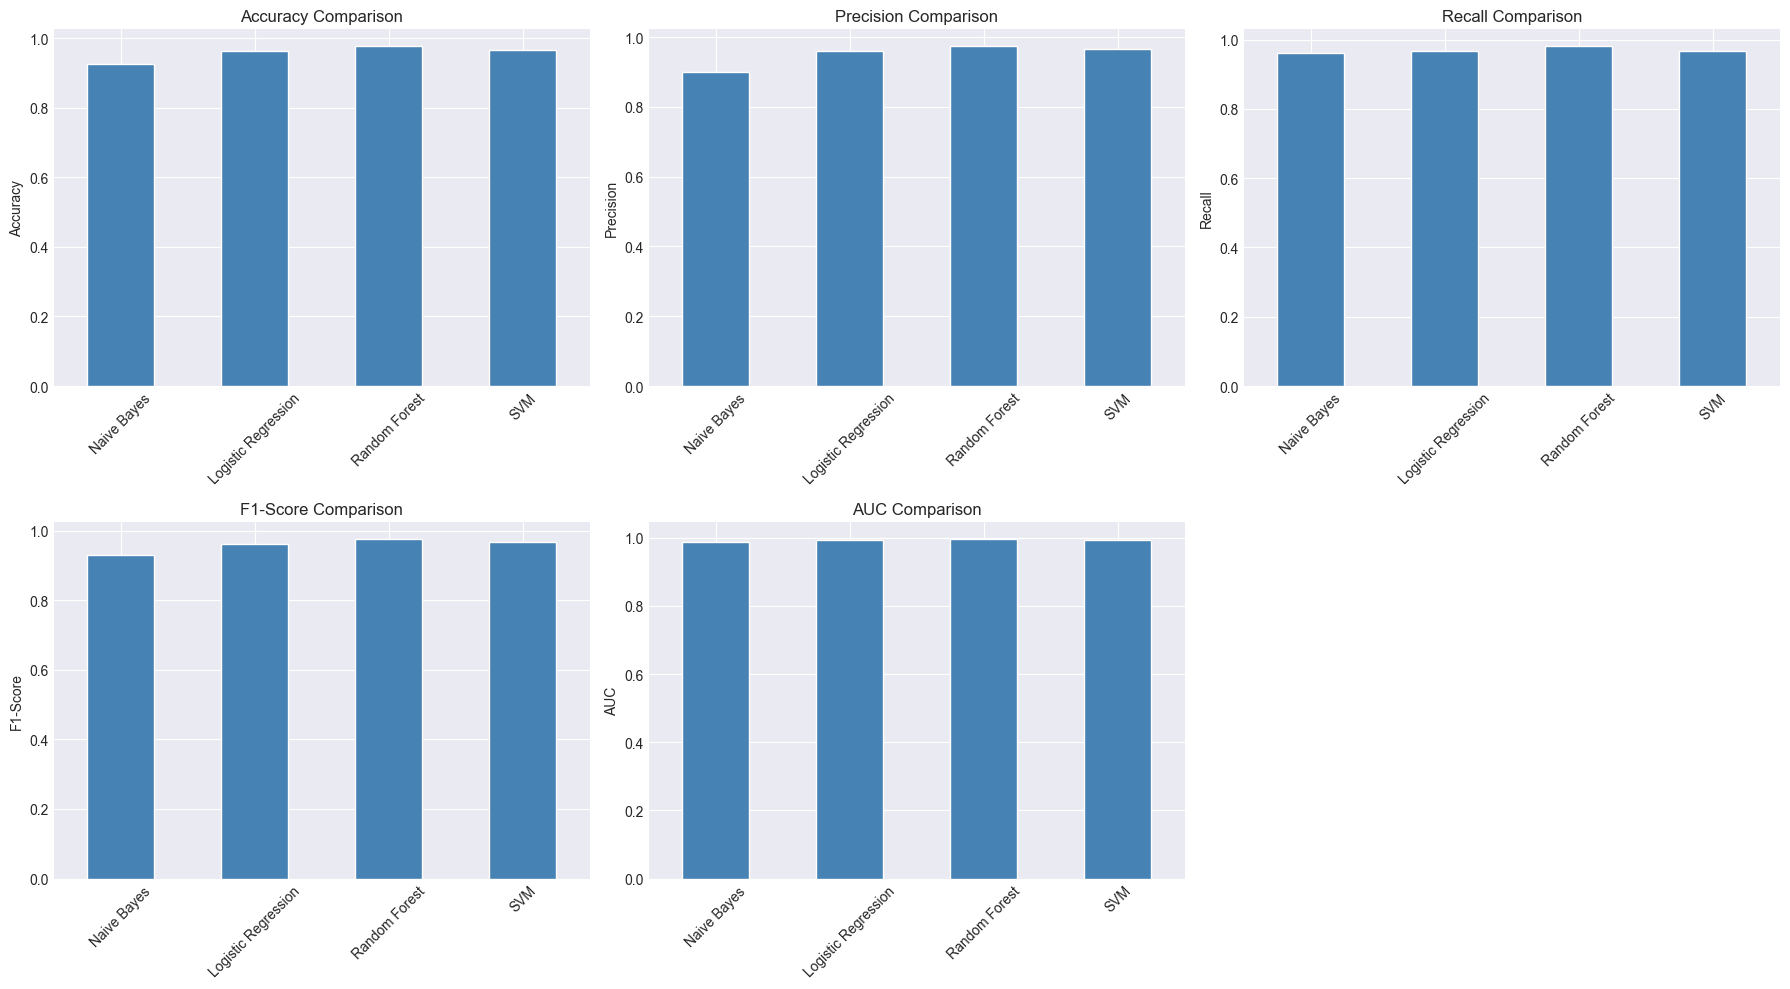

In [ ]:
# Visualize model performance
if data is not None and 'results_df' in locals():
    # 1. Confusion Matrices
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test_tfidf)
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
        axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred):.4f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # 2. ROC Curves
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Model Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. Performance Comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 3, idx % 3]
        results_df.plot(x='Model', y=metric, kind='bar', ax=ax, color='steelblue')
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        ax.set_xlabel('')
        ax.legend().remove()
        ax.tick_params(axis='x', rotation=45)
    
    # Remove empty subplot
    fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No results available for visualization")


## 7. Best Model Selection & Detailed Analysis

Select the best performing model and analyze its predictions in detail.


## 7.1 Save Trained Model for API Deployment

Save the best model and vectorizer for use in the FastAPI backend.


In [ ]:
# Save the best model and vectorizer for API deployment
import joblib
import os
from datetime import datetime

# Create models directory if it doesn't exist (at project root)
# Note: Using ../models/ because notebook is in notebooks/ folder
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

if 'best_model' in locals() and 'tfidf_vectorizer' in locals() and 'best_model_name' in locals():
    try:
        # Save the model
        model_path = os.path.join(models_dir, 'spam_detector_model.pkl')
        joblib.dump(best_model, model_path)
        print(f"✅ Model saved to: {model_path}")
        
        # Save the vectorizer
        vectorizer_path = os.path.join(models_dir, 'tfidf_vectorizer.pkl')
        joblib.dump(tfidf_vectorizer, vectorizer_path)
        print(f"✅ Vectorizer saved to: {vectorizer_path}")
        
        # Save model metadata
        metadata = {
            'model_name': best_model_name,
            'model_type': type(best_model).__name__,
            'saved_at': datetime.now().isoformat(),
            'training_samples': len(X_train) if 'X_train' in locals() else None,
            'test_samples': len(X_test) if 'X_test' in locals() else None,
            'performance': best_row.to_dict() if 'best_row' in locals() else None,
            'preprocessing': {
                'remove_stopwords': True,  # Based on our preprocessing
                'lemmatization': True,
                'lowercase': True,
                'remove_punctuation': True
            }
        }
        
        import json
        metadata_path = os.path.join(models_dir, 'model_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f"✅ Metadata saved to: {metadata_path}")
        
        print("\n" + "="*80)
        print("MODEL SAVED SUCCESSFULLY!")
        print("="*80)
        print(f"Model: {best_model_name}")
        print(f"Files created:")
        print(f"  - {model_path}")
        print(f"  - {vectorizer_path}")
        print(f"  - {metadata_path}")
        print("\n💡 These files can now be loaded in the FastAPI backend!")
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    missing = []
    if 'best_model' not in locals():
        missing.append('best_model')
    if 'tfidf_vectorizer' not in locals():
        missing.append('tfidf_vectorizer')
    if 'best_model_name' not in locals():
        missing.append('best_model_name')
    
    print(f"⚠️  Cannot save model. Missing: {', '.join(missing)}")
    print("\nPlease run the following cells first:")
    print("  1. Cell 14: Prepare data for training")
    print("  2. Cell 15: TF-IDF vectorization")
    print("  3. Cell 16: Train models")
    print("  4. Cell 19: Select best model")


In [ ]:
# Select best model based on F1-Score
if ('results_df' in locals() or 'results_df' in globals()) and ('models' in locals() or 'models' in globals()):
    if results_df is not None and len(results_df) > 0 and models is not None:
        try:
            best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
            best_model = models[best_model_name]
            
            print("="*80)
            print(f"BEST MODEL: {best_model_name}")
            print("="*80)
            print(f"\nPerformance Metrics:")
            best_row = results_df[results_df['Model'] == best_model_name].iloc[0]
            for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']:
                print(f"{metric:15s}: {best_row[metric]:.4f}")
            
            # Detailed classification report
            if 'X_test_tfidf' in locals() and 'y_test' in locals():
                y_pred_best = best_model.predict(X_test_tfidf)
                print("\n" + "="*80)
                print("DETAILED CLASSIFICATION REPORT")
                print("="*80)
                print(classification_report(y_test, y_pred_best, 
                                            target_names=['Ham', 'Spam']))
            else:
                print("\n⚠️  X_test_tfidf or y_test not found for detailed analysis")
        except Exception as e:
            print(f"⚠️  Error selecting best model: {str(e)}")
            print(f"Available models: {list(models.keys()) if models else 'None'}")
            print(f"Results DF shape: {results_df.shape if results_df is not None else 'None'}")
    else:
        print("⚠️  results_df or models is empty/None")
        print("Please run the model training cell (Cell 16) first.")
else:
    print("⚠️  No results available for best model selection")
    print("\nTo fix this:")
    print("1. Run Cell 14: Prepare data for training")
    print("2. Run Cell 15: TF-IDF vectorization")
    print("3. Run Cell 16: Train multiple models")
    print("4. Then run this cell again")


BEST MODEL: Random Forest

Performance Metrics:
Accuracy       : 0.9768
Precision      : 0.9734
Recall         : 0.9806
F1-Score       : 0.9770
AUC            : 0.9970

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.98      8811
        Spam       0.97      0.98      0.98      8910

    accuracy                           0.98     17721
   macro avg       0.98      0.98      0.98     17721
weighted avg       0.98      0.98      0.98     17721



## 8. Error Analysis

Examine misclassified examples to understand model limitations.


In [ ]:
# Error Analysis
if data is not None and 'best_model' in locals():
    y_pred_best = best_model.predict(X_test_tfidf)
    y_pred_proba_best = best_model.predict_proba(X_test_tfidf)
    
    # Create dataframe for analysis
    error_analysis = pd.DataFrame({
        'text': X_test,
        'actual': y_test.map({0: 'Ham', 1: 'Spam'}),
        'predicted': y_pred_best.map({0: 'Ham', 1: 'Spam'}),
        'confidence': np.max(y_pred_proba_best, axis=1),
        'is_correct': (y_test == y_pred_best)
    })
    
    misclassified = error_analysis[~error_analysis['is_correct']]
    
    print("="*80)
    print("ERROR ANALYSIS")
    print("="*80)
    print(f"Total misclassified: {len(misclassified)} out of {len(error_analysis)}")
    print(f"Error rate: {len(misclassified)/len(error_analysis)*100:.2f}%")
    
    # False Positives (Ham classified as Spam)
    false_positives = misclassified[misclassified['actual'] == 'Ham']
    print(f"\nFalse Positives (Ham classified as Spam): {len(false_positives)}")
    
    # False Negatives (Spam classified as Ham)
    false_negatives = misclassified[misclassified['actual'] == 'Spam']
    print(f"False Negatives (Spam classified as Ham): {len(false_negatives)}")
    
    # Show examples
    print("\n" + "="*80)
    print("FALSE POSITIVE EXAMPLES (Ham → Spam)")
    print("="*80)
    for idx, row in false_positives.head(3).iterrows():
        print(f"\nConfidence: {row['confidence']:.4f}")
        print(f"Text: {row['text'][:200]}...")
    
    print("\n" + "="*80)
    print("FALSE NEGATIVE EXAMPLES (Spam → Ham)")
    print("="*80)
    for idx, row in false_negatives.head(3).iterrows():
        print(f"\nConfidence: {row['confidence']:.4f}")
        print(f"Text: {row['text'][:200]}...")
        
else:
    print("⚠️  No model available for error analysis")


AttributeError: 'numpy.ndarray' object has no attribute 'map'

## 9. Model Deployment - Predict New Emails

Test the trained model on new, unseen email text.


In [ ]:
# Function to predict on new email text
def predict_email_spam(email_text, model, vectorizer):
    """
    Predict if an email is spam or ham
    
    Args:
        email_text: The email message text
        model: Trained classifier model
        vectorizer: Fitted TF-IDF vectorizer
    
    Returns:
        Dictionary with prediction and confidence
    """
    # Preprocess the text
    processed_text = preprocess_text(email_text)
    
    # Transform to TF-IDF features
    features = vectorizer.transform([processed_text])
    
    # Predict
    prediction = model.predict(features)[0]
    probabilities = model.predict_proba(features)[0]
    
    # Map prediction to label
    label = 'Spam' if prediction == 1 else 'Ham'
    confidence = probabilities[prediction]
    
    result = {
        'label': label,
        'confidence': confidence,
        'spam_probability': probabilities[1],
        'ham_probability': probabilities[0]
    }
    
    return result

# Test on sample emails
if data is not None and 'best_model' in locals():
    test_emails = [
        "Congratulations! You've won $1000. Click here to claim your prize now!",
        "Hi, can we schedule a meeting for tomorrow?",
        "URGENT: Your account will be suspended if you don't verify now!",
        "Thanks for your email. I'll get back to you soon.",
        "FREE MONEY!!! Click here now to get $5000 instantly!!!",
        "Hey, did you see the new update on the project we discussed?"
    ]
    
    print("="*80)
    print("TESTING MODEL ON SAMPLE EMAILS")
    print("="*80)
    
    for idx, email in enumerate(test_emails, 1):
        result = predict_email_spam(email, best_model, tfidf_vectorizer)
        print(f"\nEmail {idx}:")
        print(f"Text: {email}")
        print(f"Prediction: {result['label']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print(f"Spam Probability: {result['spam_probability']:.2%}")
        print("-" * 80)
else:
    print("⚠️  No model available for prediction")


⚠️  No model available for prediction


## 10. Conclusion & Next Steps

### Summary
- Built a comprehensive spam email detection system using multiple ML models
- Achieved high accuracy with TF-IDF feature extraction
- Identified best performing model based on multiple metrics

### Recommendations for Enhanced Accuracy

#### 1. **Email Header Analysis** (Most Important)
   - Parse SPF, DKIM, and DMARC authentication results
   - Analyze `Received` headers for routing patterns
   - Compare `From` vs `Return-Path` headers
   - Check domain reputation and age

#### 2. **Additional Datasets**
   - **SpamAssassin Dataset**: Full email headers for metadata extraction
   - **Enron Spam Corpus**: Large-scale real-world email dataset
   - **UCI Spambase**: Pre-engineered statistical features

#### 3. **Advanced NLP Techniques**
   - **BERT/Transformer models**: Use pre-trained language models for better context understanding
   - **Word embeddings**: Word2Vec, GloVe, or FastText
   - **Deep learning**: LSTM/GRU for sequential pattern recognition

#### 4. **Structural Features**
   - HTML structure analysis
   - Image-to-text ratio
   - Link count and destination analysis
   - Attachment analysis

#### 5. **Model Ensembling**
   - Combine multiple models for improved accuracy
   - Use stacking or voting classifiers
   - Weight models based on individual performance

### Deployment Considerations
- **API Development**: Create REST API using Flask/FastAPI
- **Real-time Processing**: Handle email streams efficiently
- **Monitoring**: Track model performance in production
- **Retraining**: Periodic model updates with new spam patterns
